In [1]:
import numpy as np
import scipy as sc
from scipy.interpolate import spline
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets, linear_model, metrics
from sklearn.decomposition import PCA

In [2]:
#Bring our data into handy data frames
X = pd.read_csv("RawData/Final.csv")
gspc = pd.read_csv("^GSPC(1).csv")


In [69]:
#Compute average monthly average S&P for months where we have Goldman reports
spcol = ["0214","0514","0814","1114"]
gspccol = ["2","5","8","11"]
sp = {"0214":0,"0514":0,"0814":0,"1114":0}

for i in range(0,4):# these are the months for which we have data
    val = gspccol[i]
    gspc_by_month = gspc.where(gspc["Date"].str.startswith(val))["Close"]
    iavg =gspc_by_month.mean()
    spmonth = spcol[i]
    sp[spmonth] =  iavg
print(sp) #key values pairs for average closing S&P values for the listed months



{'0214': 1843.5800048, '0514': 1889.7671420476195, '0814': 1961.5319068571428, '1114': 2038.0026612000001}


In [70]:
y1 = X['0814price']-X['0214price']
ty1 = X['1114price']-X['0514price']
x1 = pd.DataFrame()
x1['0214-0514pchng'] = X['0514price']- X['0214price']
x1['0214-0514chng']=X['0214-0514chng']
x1['0214sp'] = sp['0214']
x1['0514sp'] = sp['0514']

tx1 = pd.DataFrame()
ty1 =  X['1114price']-X['0514price']
tx1['0514-0814pchng'] = X['0814price']- X['0514price']
tx1['0514-0814chng']=X['0514-0814chng']
tx1['0514sp'] = sp['0514']
tx1['0814sp'] = sp['0814']



['0214-0514pchng', '0214-0514chng', '0214sp', '0514sp']
[  9.35155247e-01  -8.93811046e-08  -2.83241775e-42   2.83241775e-42]
[  9.88231091e-01   3.67947860e-08  -1.17472213e-39  -2.93680532e-40]
Training data performance on price:  0.449695301017


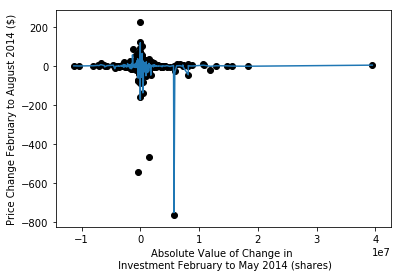

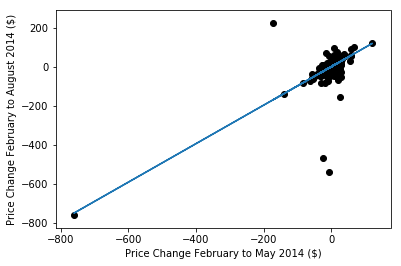

In [71]:
# Fit line using all training data
lr = linear_model.LinearRegression()
lr.fit(x1, y1)


# Robustly fit linear model with RANSAC algorithm
ransac = linear_model.RANSACRegressor()
ransac.fit(x1, y1)
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

print(list(x1))
print(lr.coef_)
print(ransac.estimator_.coef_)


y1_pred = ransac.predict(x1)
sx1 = x1.sort_values( by = '0214-0514chng')


print("Training data performance on price: ", metrics.r2_score(y1,y1_pred))


plt.plot(sx1['0214-0514chng'], ransac.predict(sx1))
plt.scatter(x1['0214-0514chng'],y1, color = "black")
plt.ylabel("Price Change February to August 2014 ($)")
plt.xlabel("Absolute Value of Change in \n Investment February to May 2014 (shares)")
plt.show()


plt.plot(sx1['0214-0514pchng'], ransac.predict(sx1))
plt.scatter(x1['0214-0514pchng'],y1, color = "black")
plt.ylabel("Price Change February to August 2014 ($)")
plt.xlabel("Price Change February to May 2014 ($)")
plt.show()



#plt.plot(sx1['0214-0514chng'], ransac.predict(sx1))
#plt.scatter(x1['0214-0514chng'],y1, color = "black")
#plt.show()

Test data performance on price:  0.605336387991


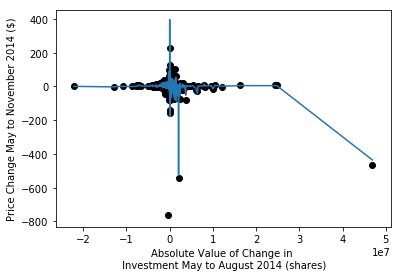

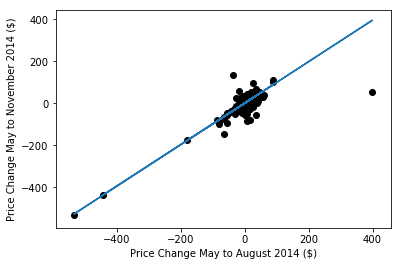

In [73]:
#Check the performance of our training set model on test set
ty1_pred = ransac.predict(tx1)

print("Test data performance on price: ", metrics.r2_score(ty1,ty1_pred))

stx1 = tx1.sort_values( by = '0514-0814chng')
plt.plot(stx1['0514-0814chng'], ransac.predict(stx1))
plt.scatter(tx1['0514-0814chng'],y1, color = "black")
plt.ylabel("Price Change May to November 2014 ($)")
plt.xlabel("Absolute Value of Change in \n Investment May to August 2014 (shares)")
plt.show()


plt.plot(stx1['0514-0814pchng'], ransac.predict(stx1))
plt.scatter(tx1['0514-0814pchng'],ty1, color = "black")
plt.ylabel("Price Change May to November 2014 ($)")
plt.xlabel("Price Change May to August 2014 ($)")
plt.show()


In [91]:
for j in range(1,5): #Fitting the data from some limited number of features, up to the full number of features
    n_components = j
    p1 = PCA(n_components= j, copy =True)
    p1.fit(x1)
    x3 =pd.DataFrame(p1.transform(x1), columns=['PCA%i' % i for i in range(n_components)], index=x1.index)


    ransac = linear_model.RANSACRegressor()
    ransac.fit(x3, y1)
    inlier_mask = ransac.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)


    y3_pred = ransac.predict(x3)
    print("With ", j, "feature(s): ")
    print(metrics.r2_score(y1,y3_pred))


With  1 feature(s): 
-0.00096549060939
With  2 feature(s): 
0.420011371714
With  3 feature(s): 
0.427753450811
With  4 feature(s): 
0.427725723015
